In [ ]:
pip install pyro-ppl

In [ ]:
#Improved Bayesian BWM

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def model(ab_lower,ab_upper, aw_lower,aw_upper):
    dm_no, c_no = aw_lower.shape
    
    wStar_prior = torch.ones(c_no) / 10000000

    # Priors
    beta = pyro.sample('beta', dist.Gamma(0.01, 0.01))
    beta2 = pyro.sample('beta2', dist.Gamma(0.01, 0.01))
    theta = pyro.sample('theta', dist.Dirichlet(wStar_prior))

    wStar = pyro.sample('wStar', dist.Dirichlet(beta2 * theta))
    w = pyro.sample('w', dist.Dirichlet(beta * wStar).expand_by((dm_no,)))
    print(w)
    # Likelihoods
    obs_ab = torch.tensor(np.zeros([dm_no,c_no]))
    obs_aw = torch.tensor(np.zeros([dm_no,c_no]))

    for i in range(dm_no):
        for j in range(c_no):
            if ab_lower[i,j] == ab_upper[i,j]:
                obs_ab[i,j] = ab_lower[i,j]
            else:
                obs_zab = pyro.sample(f'obs_zab_{i,j}',dist.Normal(0,1))
                obs_ab[i,j] = obs_zab
            if aw_lower[i,j] == aw_upper[i,j]:
                obs_aw[i,j] = aw_lower[i,j]
            else:
                obs_zaw = pyro.sample(f'obs_zaw_{i,j}',dist.Normal(0,1))
                obs_ab[i,j] = obs_zaw
        pyro.sample(f'obs_ab_{i}',dist.Multinomial(total_count=20, probs=1/w[i]), obs=obs_ab[i])
        pyro.sample(f'obs_aw_{i}', dist.Multinomial(total_count=20, probs=w[i].T), obs=obs_aw[i])

def BayesianBWM_PYRO(ab_lower,ab_upper, aw_lower,aw_upper):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_samples=200, warmup_steps=20, num_chains=1)
    mcmc.run(ab_lower,ab_upper, aw_lower,aw_upper)
    mcmc.summary()
    wStar_samples = mcmc.get_samples()['wStar']
    wStar_mean = torch.mean(wStar_samples, axis=0)
    print("The average of the aggregated weight distribution is:", wStar_mean)

    return wStar_mean, wStar_samples

# Example weight matrix
A_B =  torch.tensor([
       [3, 4, 6, 1, 5, 2, 9, 7],
       [1, 2, 8, 4, 5, 3, 9, 6],
       [2, 2, 3, 1, 5, 5, 9, 8],
       [2, 1, 8, 2, 9, 3, 8, 8],
       [2, 4, 9, 1, 4, 3, 5, 5],
       [1, 2, 9, 1, 3, 5, 5, 4]])
A_B2 =  torch.tensor([
       [3, 4, 6, 1, 5, 2, 9, 8],
       [1, 2, 8, 4, 5, 3, 9, 6],
       [2, 2, 3, 1, 5, 5, 9, 8],
       [2, 1, 8, 2, 9, 3, 8, 8],
       [2, 4, 9, 1, 4, 3, 5, 5],
       [1, 2, 9, 1, 3, 5, 5, 4]])

A_W =  torch.tensor([
      [ 7, 6, 4, 9, 5, 8, 1, 3],
      [ 9, 8, 2, 5, 4, 5, 1, 3],
      [ 8, 8, 5, 9, 5, 5, 1, 2],
      [ 8, 9, 2, 8, 1, 8, 2, 2],
      [ 8, 6, 1, 9, 6, 7, 4, 4],
      [ 9, 8, 1, 9, 7, 5, 5, 6]])
A_W2 =  torch.tensor([
      [ 7, 6, 4, 9, 5, 8, 1, 4],
      [ 9, 8, 2, 5, 4, 5, 1, 3],
      [ 8, 8, 5, 9, 5, 5, 1, 2],
      [ 8, 9, 2, 8, 1, 8, 2, 2],
      [ 8, 6, 1, 9, 6, 7, 4, 4],
      [ 9, 8, 1, 9, 7, 5, 5, 6]])

wStar_mean, wStar_samples = BayesianBWM_PYRO(A_B, A_B2, A_W, A_W2)


In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def model(ab, aw):
    dm_no, c_no = aw.shape
    
    wStar_prior = torch.ones(c_no) / 10000000

    # Priors
    beta = pyro.sample('beta', dist.Gamma(0.01, 0.01))
    beta2 = pyro.sample('beta2', dist.Gamma(0.01, 0.01))
    theta = pyro.sample('theta', dist.Dirichlet(wStar_prior))

    wStar = pyro.sample('wStar', dist.Dirichlet(beta2 * theta))
    w = pyro.sample('w', dist.Dirichlet(beta * wStar).expand_by((dm_no,)))

    # Likelihoods
    for i in range(dm_no):
        pyro.sample('obs_ab' + str(i), dist.Multinomial(total_count=20, probs=1/w[i]), obs=obs_ab[i])
        pyro.sample('obs_aw' + str(i), dist.Multinomial(total_count=20, probs=w[i].T), obs=obs_aw[i])

def BayesianBWM_PYRO(ab, aw):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_samples=200, warmup_steps=20, num_chains=1)
    mcmc.run(ab, aw)
    mcmc.summary()
    wStar_samples = mcmc.get_samples()['wStar']
    wStar_mean = torch.mean(wStar_samples, axis=0)
    print("The average of the aggregated weight distribution is:", wStar_mean)

    return wStar_mean, wStar_samples

# Example weight matrix
A_B =  torch.tensor([
       [3, 4, 6, 1, 5, 2, 9, 7],
       [1, 2, 8, 4, 5, 3, 9, 6],
       [2, 2, 3, 1, 5, 5, 9, 8],
       [2, 1, 8, 2, 9, 3, 8, 8],
       [2, 4, 9, 1, 4, 3, 5, 5],
       [1, 2, 9, 1, 3, 5, 5, 4]])

A_W =  torch.tensor([
      [ 7, 6, 4, 9, 5, 8, 1, 3],
      [ 9, 8, 2, 5, 4, 5, 1, 3],
      [ 8, 8, 5, 9, 5, 5, 1, 2],
      [ 8, 9, 2, 8, 1, 8, 2, 2],
      [ 8, 6, 1, 9, 6, 7, 4, 4],
      [ 9, 8, 1, 9, 7, 5, 5, 6]])

wStar_mean, wStar_samples = BayesianBWM_PYRO(A_B, A_W)


In [ ]:
import numpy as np
import pymc3 as pm

def BayesianBWM(ab, aw):
    dm_no, c_no = aw.shape

    wStar_prior = np.ones(c_no) / 10000000

    with pm.Model() as model:
        # Priors
        beta = pm.Gamma('beta', alpha=0.01, beta=0.01)
        beta2 = pm.Gamma('beta2', alpha=0.01, beta=0.01)
        theta = pm.Dirichlet('theta', a=wStar_prior)

        # Multinomial likelihoods
        wStar = pm.Dirichlet('wStar', a=beta2 * theta)
        w = pm.Dirichlet('w', a=beta * wStar, shape=(dm_no, c_no))
        ab_obs = pm.Multinomial('ab_obs', n=ab.sum(axis=1), p=w, observed=ab)
        aw_obs = pm.Multinomial('aw_obs', n=aw.sum(axis=1), p=w.T, observed=aw)

    with model:
        trace = pm.sample(draws=1000, tune=200, chains=4, cores=4)

    wStar_samples = trace['wStar']
    wStar_mean = np.mean(wStar_samples, axis=0)
    print("The average of the aggregated weight distribution is:", wStar_mean)

    return wStar_mean, wStar_samples

# Example usage
ab = np.array([[1, 2, 5], [1, 8, 2]])  # Example evaluation matrix
aw = np.array([[3, 4, 3], [2, 6, 2]])  # Example weight matrix

wStar_mean, wStar_samples = BayesianBWM(ab, aw)


In [ ]:
#Bayesian BWM
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def model(ab, aw):
    dm_no, c_no = aw.shape
    
    wStar_prior = torch.ones(c_no) / 10000000

    # Priors
    beta = pyro.sample('beta', dist.Gamma(0.01, 0.01))
    beta2 = pyro.sample('beta2', dist.Gamma(0.01, 0.01))
    theta = pyro.sample('theta', dist.Dirichlet(wStar_prior))

    wStar = pyro.sample('wStar', dist.Dirichlet(beta2 * theta))
    w = pyro.sample('w', dist.Dirichlet(beta * wStar).expand_by((dm_no,)))
    print(w)
    # Likelihoods
#     total_count = torch.tensor(ab.sum(axis=1)).float().mean().item()
#     print(total_count)
    for i in range(dm_no):
        pyro.sample('ab_' + str(i), dist.Multinomial(total_count=20, probs=1/w[i]), obs=ab[i])
        pyro.sample('aw_' + str(i), dist.Multinomial(total_count=20, probs=w[i].T), obs=aw[i])

def BayesianBWM_PYRO(ab, aw):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_samples=200, warmup_steps=20, num_chains=1)
    mcmc.run(ab.to(device), aw.to(device))
    mcmc.summary()
    wStar_samples = mcmc.get_samples()['wStar']
    wStar_mean = torch.mean(wStar_samples, axis=0)
    print("The average of the aggregated weight distribution is:", wStar_mean)

    return wStar_mean, wStar_samples

A_B_impre =  [
       [[2,3], [3,4], 1, 3, 9],
       [[3,4], [2,3], 1, 9, [7,8]],
       [1, [2,3], 3, [2,3], 9]]

A_W_impre =  [
       [7, [5,6], 9, [6,7], 1],
       [[5,6], [6,7], 9, 1, 3],
       [9, 7, [5,6], [6,7], 1]]

A_B = np.zeros([3,5])
A_W = np.zeros([3,5])
for i in range(3):
    for j in range(5):
        if isinstance(A_B_impre[i,j],int)== False
            A_B[i,j] = np.random.randint(A_B_impre[i,j][0],A_B_impre[i,j][1])
        else:
            A_B[i,j] = A_B_impre[i,j]
        if isinstance(A_W_impre[i,j],int)== False
            A_W[i,j] = np.random.randint(A_W_impre[i,j][0],A_W_impre[i,j][1])
        else:
            A_W[i,j] = A_W_impre[i,j]
wStar_mean, wStar_samples = BayesianBWM_PYRO(A_B, A_W)


<Figure size 1000x600 with 0 Axes>

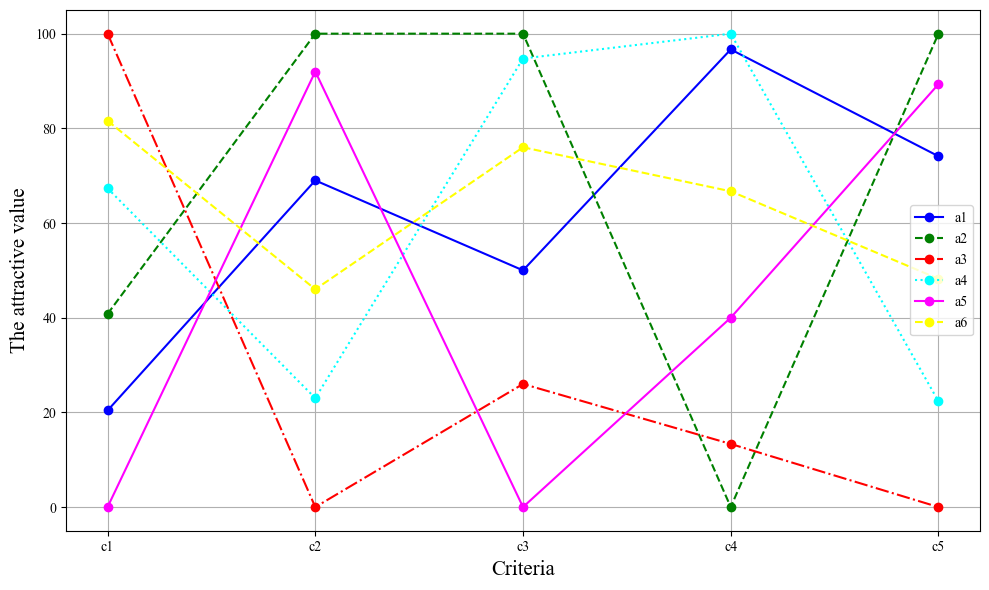

In [3]:
#figure
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'a1': [20.40, 69, 50, 96.67, 74.11],
    'a2': [40.8, 100.00, 100.00, 0, 100.00],
    'a3': [100.00, 0.00, 26.00, 13.33, 0.00],
    'a4': [67.33, 23, 94.75, 100.00, 22.33],
    'a5': [0.00, 92.00, 0.00, 40.0, 89.33],
    'a6': [81.60, 46.00, 76.00, 66.70, 48.22]
}

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
line_styles = ['-', '--', '-.', ':']
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

categories = ['c1', 'c2', 'c3', 'c4', 'c5']

# Set the categories as the index of the DataFrame
df.index = categories

plt.figure(figsize=(10, 6))

# Plot each column with a unique style and color
for i, column in enumerate(df.columns):
    plt.plot(df.index, df[column], line_styles[i % len(line_styles)], color=colors[i],
             marker='o', label=column)


plt.xlabel('Criteria',fontsize = 15)
plt.ylabel('The attractive value',fontsize = 15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('The numerical value.jpg',dpi=500)
plt.show()
 

In [ ]:
# BWM
import pandas as pd
import numpy as np
import gurobipy as gp
import sys
from gurobipy import GRB

def bwm(best_to_others, worst_to_others,best_criteria,worst_criteria):
    n = len(best_to_others)  # Number of criteria excluding the best one 

    # Create a new model
    model = gp.Model("BWM")

    # Create variables for weights
    weights = model.addVars(n, lb=0, ub=1, name="Weights")  # n because best and worst criteria are also included
    model.update()

    # Add the constraint that sum of weights should be 1
    model.addConstr(weights.sum() == 1, "Normalization")

    # Consistency variables
    v_plus = model.addVar(lb=0, ub=GRB.INFINITY, name="v_plus")
    
    best_criteria = best_criteria[0]
    worst_criteria = worst_criteria[0]
    # Add constraints based on best_to_others and worst_to_others comparisons
    for j, value in enumerate(best_to_others):  # Starting at 1 because 0 is the best criteria itself
        model.addConstr(weights[best_criteria] - value * weights[j] <= v_plus*weights[j], f"ConsistencyBest_{j}")
        model.addConstr(weights[best_criteria] - value * weights[j] >= -v_plus*weights[j], f"ConsistencyBestNeg_{j}")

    for j, value in enumerate(worst_to_others):
        if j == worst_criteria:  # Skip the comparison if j is the worst criteria itself
            continue
        model.addConstr( weights[j] - value *weights[worst_criteria] <= v_plus * weights[worst_criteria], f"ConsistencyWorst_{j}")
        model.addConstr( weights[j] - value *weights[worst_criteria] >= -v_plus* weights[worst_criteria], f"ConsistencyWorstNeg_{j}")

    # Set objective: minimize the maximum inconsistency
    model.setObjective(v_plus, GRB.MINIMIZE)
    model.Params.NonConvex = 2
    model.Params.MIPGap=0 # 百分比界差
    # Optimize model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        return {var.varName: var.x for var in model.getVars() if 'Weights' in var.varName}
    else:
        return None

A_B_impre =  [
       [[2,3], [3,4], 1, 3, 9],
       [[3,4], [2,3], 1, 9, [7,8]],
       [1, [2,3], 3, [2,3], 9]]

A_W_impre =  [
       [7, [5,6], 9, [6,7], 1],
       [[5,6], [6,7], 9, 1, 3],
       [9, 7, [5,6], [6,7], 1]]

def data_gen(A_B_impre,A_W_impre):
    A_B = np.zeros([3,5])
    A_W = np.zeros([3,5])
    for i in range(3):
        for j in range(5):
            if isinstance(A_B_impre[i][j],int)== False:
                A_B[i,j] = np.random.randint(A_B_impre[i][j][0],A_B_impre[i][j][1]+1)
            else:
                A_B[i,j] = A_B_impre[i][j]
            if isinstance(A_W_impre[i][j],int)== False:
                A_W[i,j] = np.random.randint(A_W_impre[i][j][0],A_W_impre[i][j][1]+1)
            else:
                A_W[i,j] = A_W_impre[i][j]
    return A_B,A_W
record = np.zeros([1000,5])
for j in range(1000):
    A_B,A_W = data_gen(A_B_impre,A_W_impre)
    for i in range(3):
        
        A_b = A_B[i]
        A_w = A_W[i]
        best = np.where(A_b==1)[0].tolist()
        worst = np.where(A_b==1)[0].tolist()
        weights = bwm(A_b, A_w, best, worst)
        for index,item in enumerate(weights.values()):
            record[j,index] = record[j,index]+item
    record[j,:] =  record[j,:]/3

In [ ]:
# 创建一个 Pandas 的 DataFrame
df = pd.DataFrame(record)

# 指定要写入的 Excel 文件路径
excel_file = 'output.xlsx'

# 使用 Pandas 的 to_excel 方法将 DataFrame 写入 Excel 文件
df.to_excel(excel_file, index=False)


In [5]:
#Improved Bayesian BWM

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def model(ab_lower,ab_upper, aw_lower,aw_upper):
    dm_no, c_no = aw_lower.shape
    
    wStar_prior = torch.ones(c_no) / 10000000

    # Priors
    beta = pyro.sample('beta', dist.Gamma(0.01, 0.01))
    beta2 = pyro.sample('beta2', dist.Gamma(0.01, 0.01))
    theta = pyro.sample('theta', dist.Dirichlet(wStar_prior))

    wStar = pyro.sample('wStar', dist.Dirichlet(beta2 * theta))
    w = pyro.sample('w', dist.Dirichlet(beta * wStar).expand_by((dm_no,)))
    print(w)
    # Likelihoods
    obs_ab = torch.tensor(np.zeros([dm_no,c_no]))
    obs_aw = torch.tensor(np.zeros([dm_no,c_no]))

    for i in range(dm_no):
        for j in range(c_no):
            if ab_lower[i,j] == ab_upper[i,j]:
                obs_ab[i,j] = ab_lower[i,j]
            else:
                integers = torch.arange(ab_upper[i,j]-ab_lower[i,j]+1)  # 生成0到9的整数张量
                probabilities = torch.ones_like(integers) / len(integers)  # 每个整数等概率
                Categorical = pyro.distributions.Categorical(torch.tensor([probabilities]))
                obs_zab = Categorical.sample()
                obs_ab[i,j] = ab_lower[i,j]+obs_zab.item()
#                 obs_zab = np.random.randint(ab_lower[i,j],ab_upper[i,j]+1)
            if aw_lower[i,j] == aw_upper[i,j]:
                obs_aw[i,j] = aw_lower[i,j]
            else:
                integers = torch.arange(aw_upper[i,j]-aw_lower[i,j]+1)  # 生成0到9的整数张量
                probabilities = torch.ones_like(integers) / len(integers)  # 每个整数等概率
                Categorical = pyro.distributions.Categorical(torch.tensor([probabilities]))
                obs_zaw = Categorical.sample()
                obs_aw[i,j] = aw_lower[i,j]+obs_zaw.item()
#                 obs_zaw = np.random.randint(aw_lower[i,j],aw_upper[i,j]+1)
#                 obs_ab[i,j] = obs_zaw
        pyro.sample(f'obs_ab_{i}',dist.Multinomial(total_count=20, probs=1/w[i]), obs=obs_ab[i])
        pyro.sample(f'obs_aw_{i}',dist.Multinomial(total_count=20, probs=w[i].T), obs=obs_aw[i])

def BayesianBWM_PYRO(ab_lower,ab_upper, aw_lower,aw_upper):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_samples=10000, warmup_steps=100, num_chains=1)
    mcmc.run(ab_lower,ab_upper, aw_lower,aw_upper)
    mcmc.summary()
    plot_diagnostics(mcmc)
    wStar_samples = mcmc.get_samples()['wStar']
    wStar_mean = torch.mean(wStar_samples, axis=0)
    print("The average of the aggregated weight distribution is:", wStar_mean)

    return wStar_mean, wStar_samples

# Example weight matrix
A_B =  torch.tensor([
       [2, 3, 1, 3, 9],
       [3, 2, 1, 9, 7],
       [1, 2, 3, 2, 9]])

A_B2 =  torch.tensor([
       [3, 4, 1, 3, 9],
       [4, 3, 1, 9, 8],
       [1, 3, 3, 3, 9]])

A_W =  torch.tensor([
       [7, 5, 9, 6, 1],
       [5, 6, 9, 1, 3],
       [9, 7, 5, 6, 1]])
A_W2 =  torch.tensor([
       [7, 6, 9, 7, 1],
       [6, 7, 9, 1, 3],
       [9, 7, 6, 7, 1]])

wStar_mean, wStar_samples = BayesianBWM_PYRO(A_B, A_B2, A_W, A_W2)


Warmup:   0%|                                                                                  | 0/10100 [00:00, ?it/s]

tensor([[4.6143e-07, 7.3127e-10, 2.0285e-01, 1.4508e-02, 7.8264e-01],
        [1.8678e-07, 7.6263e-01, 6.5717e-21, 9.7944e-03, 2.2757e-01],
        [2.2794e-07, 1.3322e-04, 1.6533e-08, 9.9918e-01, 6.8235e-04]])


ValueError: only one element tensors can be converted to Python scalars
Trace Shapes:      
 Param Sites:      
Sample Sites:      
    beta dist   |  
        value   |  
   beta2 dist   |  
        value   |  
   theta dist   | 5
        value   | 5
   wStar dist   | 5
        value   | 5
       w dist 3 | 5
        value 3 | 5

In [140]:
wStar_samples

tensor([[0.2061, 0.2075, 0.3284, 0.1733, 0.0847],
        [0.2200, 0.1616, 0.3659, 0.1805, 0.0720],
        [0.2741, 0.3324, 0.2325, 0.1116, 0.0495],
        ...,
        [0.1936, 0.2667, 0.3600, 0.1192, 0.0605],
        [0.3335, 0.1321, 0.3241, 0.1222, 0.0881],
        [0.1824, 0.3324, 0.3369, 0.0974, 0.0508]], dtype=torch.float64)

In [138]:
import arviz as az
import matplotlib.pyplot as plt

def plot_diagnostics(mcmc):
    # Convert Pyro MCMC samples to ArviZ's InferenceData format for diagnostics
    posterior_samples = mcmc.get_samples()
    inference_data = az.convert_to_inference_data({k: v.unsqueeze(0) for k, v in posterior_samples.items()})
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    # Trace plot for 'wStar'
    az.plot_trace(inference_data, var_names=['wStar'])
    plt.savefig('plot_trace.jpg',dpi=2000)
    plt.show()

    # Autocorrelation plot for 'wStar'
    az.plot_autocorr(inference_data, var_names=['wStar'])
    plt.savefig('autocorr.jpg',dpi=2000)
    plt.show()

    # Summary statistics including R-hat and ESS
    summary_stats = az.summary(inference_data)
    print(summary_stats)

In [144]:
df = pd.DataFrame(wStar_samples.numpy().astype(float))

# 写入Excel文件
df.to_excel('Imprv_BWM.xlsx', engine='openpyxl')

Warmup:   0%|                                                                                  | 0/250 [4:53:50, ?it/s]


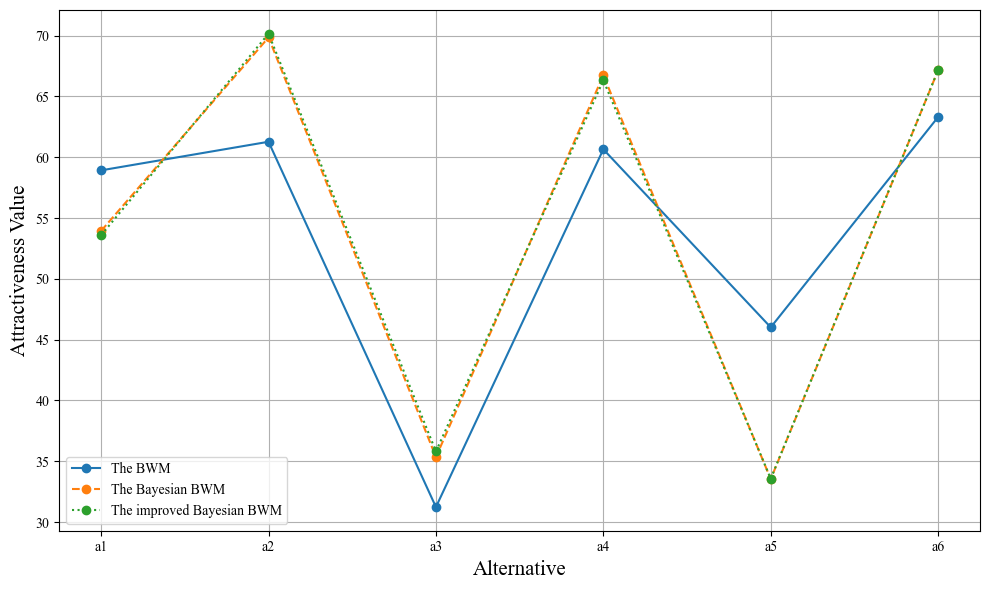

In [7]:
methods = ['The BWM 1', 'The Bayesian BWM', 'The improved Bayesian BWM']
items = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6']
attractiveness_scores = {
    'The BWM': [58.92, 61.27, 31.23, 60.65, 46.01, 63.31],
    'The Bayesian BWM': [53.94, 69.85, 35.34, 66.74, 33.53, 67.16],
    'The improved Bayesian BWM': [53.59, 70.16, 35.80, 66.32, 33.56, 67.17]
}

# 设置图表的风格和大小
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
# 为每个方法绘制折线图
for method, scores in attractiveness_scores.items():
    # 根据需要选择不同的线型
    linestyle = '-' if method == 'The BWM' else '--' if method == 'The Bayesian BWM' else ':'
    plt.plot(items, scores, label=method, linestyle=linestyle,marker='o')

# 添加图例
plt.legend()

# 添加标题和坐标轴标签
# plt.title('Attractiveness Scores for Different Methods')
plt.xlabel('Alternative',fontsize = 15)
plt.ylabel('Attractiveness Value',fontsize = 15)

# 显示网格
plt.grid(True)
plt.tight_layout()
plt.savefig('The ranking orders of different methods.jpg',dpi=2000)
# 显示图表
plt.show()
